# Vision Transformer

Η δημοσίευση του Vision Transformer βρίσκεται [εδώ](https://arxiv.org/abs/2010.11929). Σε αυτό το notebook θα χρησιμοποιήσουμε την υλοποίηση του [Brian Pulfer](https://www.brianpulfer.ch/blog/vit) και στο τέλος θα την συγκρίνουμε την υλοποίηση της [PyTorch](https://pytorch.org/vision/main/models/vision_transformer.html).

![ViT Model](./resources/ViT_Steps.png)

Τα βήματα που θα ακολουθήσουμε για να φτιάξουμε τον Vision Transformer είναι τα εξής:
1. Μετατροπή των εικόνων σε patches
2. Δημιουργία των token με χρήση Linear Embedding στα patches
3. Δημιουργία του token κατηγοριοποίησης
4. Πρόσθεση του positional embedding σε κάθε token
5. Embedding Layer
6. Κατηγοριοποίηση

**TODO: Να τα φτιάξω για να δουλεύει σε απλή Python Version, τύπου 3.8-3.9 ή 3.10**

Πριν προχωρήσουμε θα χρειαστεί να φτιάξουμε ένα virtual environment και
να κατεβάσουμε όλες τις απαραίτηες βιβλιοθήκες.

In [ ]:
%pip install venv
!python3 -m venv .venv
%pip install -r requirements.txt 

In [14]:
import torch
from torchvision.models import VisionTransformer
from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
from tqdm.auto import tqdm, trange

from utils.plotting import plot_results, show_metrics, save_metrics, plot_results
from utils.train_loop import train_loop
from utils.patchifying import show_patches

## Βήμα 0: Σύνολο δεδομένων

Θα χρησιμοποίησουμε το σύνολο δεδομένων **MNIST**, το οποίο έχει $28 \times 28$ grayscale εικόνες. Περισσότερες πληροφορίες για το Dataset βρίσκονται [εδώ](https://en.wikipedia.org/wiki/MNIST_database).

Τα αντικείμενα της κλάσης `torchvision.datasets.mnist.MNIST()` μας επιστρέφουν ένα tuple εικόνας και target `(img, target)`. Στην πρώτη θέση έχουμε μια [PIL εικόνα](https://python-pillow.org/) και στην δεύτερη το label της εικόνας. Οι εικόνες στην μορφή που βρίσκονται
αυτή την στιγμή δεν μπορούν να χρησιμοποιηθούν, θα χρειαστούν τροποποίηση.

Με την `torchvision.transforms.ToTensor()` μπορούμε να μετατρέψουμε τις 
εικόνες των συνόλων σε tensors.

In [2]:
transform = ToTensor()

train_set = MNIST(root="./data", train=True, download=True, transform=transform)
test_set = MNIST(root="./data", train=False, download=True, transform=transform)

print(f"Train set size: {len(train_set)}, Test set size: {len(test_set)}")

Train set size: 60000, Test set size: 10000


Βλέπουμε ότι για το training split έχουμε $60.000$ εικόνες, ενώ για το test έχουμε $10.000$.

Πριν προχωρήσουμε στην κατασκευή του Vision Transformer είναι σημαντικό να φτιάξουμε έναν `DataLoader` για κάθε set. Είναι πολύ χρήσιμο, καθώς είναι iterator. Δεν χρειάζεται δηλαδή να φορτώσουμε *όλο* το σύνολο δεδομένων στην μνήμη. Φορτώνουμε μόνο όσα χρειάζομαστε στην επανάληψη που βρισκόμαστε, ανάλογα με το `batch_size`.

Με την χρήση της `shuffle` παραμέτρου το dataset θα ανακατευτεί μετά από κάθε epoch.

In [3]:
BATCH_SIZE = 128
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

Το παρακάτω cell μας δείχνει μια από τις εικόνες του train dataset. Εκτυπώνουμε μια εικόνα από το `train_set` και όχι από το `train_loader`, καθώς θα χρειαζόταν να κάνουμε την αντίστροφη διαδικασία που ακολουθήσαμε για να φτιάξουμε τους dataloaders.

Για να δούμε κάποια άλλη εικόνα αρκεί να αλλάξουμε την τιμή του `index`.

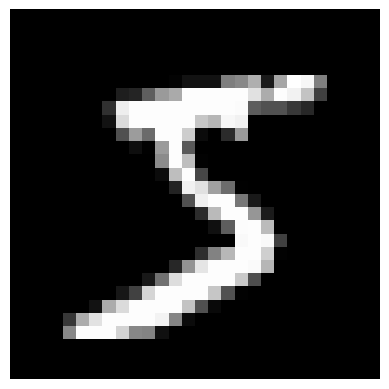

In [4]:
index = 0                       # From 0 to 59.999
image = train_set[index][0]
image = image.transpose(0, 1).transpose(1, 2)
plt.axis("off")
plt.imshow(image, cmap="gray")

## Βήμα 1: Δημιουργία των Patches

Το σύνολο δεδομένων εκπαίδευσης έχει μέγεθος $(n, c, h, w)$, όπου $n$ είναι ο αριθμός δειγμάτων, $c$ ο αριθμός των καναλιών και $h, \, w$ το ύψος και το πλάτος κάθε εικόνας.

Για να φτιάξουμε τα patches της εικόνας θα χρειαστεί να επιλέξουμε έναν αριθμό $p$. To πλήθος των patches περιγράφεται από την σχέση $$m=\frac{hw}{p^2}$$

Τα σύνολο μας έχει μέγεθος $(60.000, 1, 28, 28)$. Θα επιλέξουμε $p=4$, άρα θα έχουμε $49$ patches. Κάθε patch θα είναι μεγέθους $p \times p$, για εμάς $4 \times 4$. Συνολικά, η εικόνα θα έχει $7 \times 7$ patches, άρα το dataset θα έχει το εξής μέγεθος:
$$
(60.000, 7, 7, 4, 4)
$$

Για να προχωρήσουμε θα χρειαστεί να κάνουμε flatten αυτές τις καινούριες διαστάσεις. Θα γίνει δηλαδή $$(60.000, 49, 16)$$


<img src="./resources/Patches.png" alt="Patches" width="500"/>

Με το παρακάτω κελί μπορούμε να δούμε σε τι κομμάτια θα σπάσει η εικόνα
που διαλέξαμε από το training set πιο πάνω.

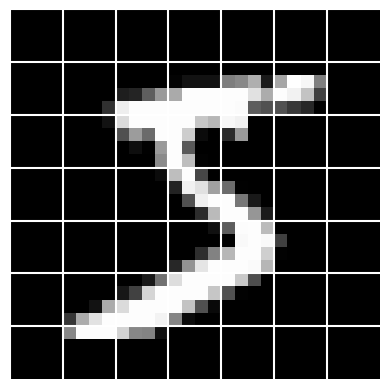

In [6]:
show_patches(image)

In [5]:
def patchify(images, n_patches):
    n, c, h, w = images.shape
    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches**2, h * w * c // n_patches**2)
    patch_size = h // n_patches
    patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.flatten(2, 3).flatten(3, 4).flatten(1, 2)
    return patches

## Βήμα 2: Linear Embedding

Τώρα θα χρειαστεί να μετατρέψουμε τα patches που φτιάξαμε σε tokens, όπως γίνεται και στον παραδοσιακό Transformer.

Το μόνο που θα χρειαστεί να πειράξουμε είναι το `hidden_d`, το οποίο είναι Hyperparameter. Στο παράδειγμα μας θα χρησιμοποιήσουμε `hidden_d=8`. Το `input_d` είναι $p^2$, άρα στην περίπτωση μας είναι $16$. 

In [7]:
class MyViT(torch.nn.Module):
    def __init__(self, chw=(1, 28, 28), n_patches=7):
        super(MyViT, self).__init__()

        self.chw = chw  # (C, H, W)
        self.n_patches = n_patches

        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = torch.nn.Linear(self.input_d, self.hidden_d)

    def forward(self, images):
        patches = patchify(images, self.n_patches)
        tokens = self.linear_mapper(patches)
        return tokens

## Βήμα 3: Classification token \<cls\>

Είναι μια learnable παράμετρος του μοντέλου. Θα πρέπει να το προσθέσουμε 
στα tokens που φτιάξαμε στο προηγούμενο βήμα.

Το μέγεθος του είναι `(1, hidden_d)`. Μαζί με αυτό, το μέγεθος των token θα είναι τώρα $(60.000, 50, 16)$

Ενημερώνουμε την κλάση MyViT με το \<cls\> token. 

In [8]:
class MyViT(torch.nn.Module):
    def __init__(self, chw=(1, 28, 28), n_patches=7):
        super(MyViT, self).__init__()

        self.chw = chw  # (C, H, W)
        self.n_patches = n_patches

        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)
        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = torch.nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classifiation token
        self.class_token = torch.nn.Parameter(torch.rand(1, self.hidden_d))

    def forward(self, images):
        patches = patchify(images, self.n_patches)
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.stack(
            [torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))]
        )

        return tokens

## Βήμα 4: Positional Encoding

Η αρχιτεκτονική του μοντέλου ως τώρα δεν αποθηκεύει πουθενά ως πληροφορία την θέση του κάθε patch στην εικόνα. Επειδή όμως έχει σημασία αν κάποιο patch είναι πάνω αριστερά, κάτω δεξιά ή οπουδήποτε αλλού στην εικόνα, θα χρειαστεί να φτιάξουμε τα positional embeddings.

Υπολογίζονται με βάση τα μεγέθη `sequence_length` και `hidden_d`. Στο notebook έχουμε τις τιμές $50$ και $8$ αντίστοιχα. Το `sequence_length` μπορούμε να το σκεφτούμε ως το πλήθος των token για κάθε εικόνα.

In [8]:
def get_positional_embeddings(sequence_length, hidden_d):
    result = torch.ones(sequence_length, hidden_d)

    for i in range(sequence_length):
        for j in range(hidden_d):
            result[i][j] = (
                np.sin(i / (10000 ** (j / hidden_d)))
                if j % 2 == 0
                else np.cos(i / (10000 ** ((j - 1) / hidden_d)))
            )
    return result

Με τον παρακάτω κώδικα μπορούμε να δούμε τις τιμές των positional encodings,
που υπολογίζονται από την `get_positional_embeddings()`

Βλέπουμε πως έχουμε 8 στήλες, αφού δώσαμε για `hidden_d` την τιμή 8.
Στις σειρές έχουμε 49 tokens + το 1 \<cls\> token, άρα 50.

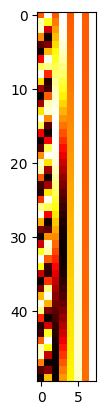

In [12]:
plt.imshow(get_positional_embeddings(49 + 1, 8), cmap="hot", interpolation="nearest")
plt.show()

**TODO: τι ακριβώς να γράψω εδώ;**

Είναι ενδιαφέρον να δούμε τα positional embeddings για μεγαλύτερες τιμές,
για να δούμε πιο ξεκάθαρα πως πράγματι είναι τιμές ημιτόνου και συνημιτόνου
σε διάφορες ???

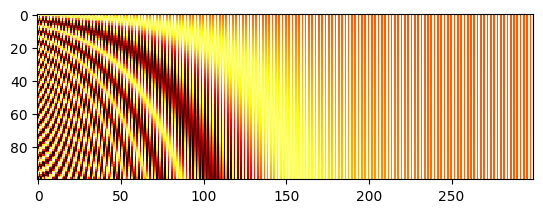

In [11]:
plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
plt.show()

Ενημερώνουμε την `MyViT` κλάση ως εξής:

In [11]:
class MyViT(torch.nn.Module):
    def __init__(self, chw=(1, 28, 28), n_patches=7):
        super(MyViT, self).__init__()

        self.chw = chw  # (C, H, W)
        self.n_patches = n_patches

        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = torch.nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classifiation token
        self.class_token = torch.nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.pos_embed = torch.nn.Parameter(
            torch.tensor(
                get_positional_embeddings(self.n_patches**2 + 1, self.hidden_d)
            )
        )
        self.pos_embed.requires_grad = False

    def forward(self, images):
        patches = patchify(images, self.n_patches)
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.stack(
            [torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))]
        )

        # Adding positional embedding
        pos_embed = self.pos_embed.repeat(n, 1, 1)

        out = tokens + pos_embed
        return out

## Βήμα 5: Encoder Module

**TODO: Μήπως να το σπάσω ένα ένα, ή είναι πολύ πληροφορία;**

Σε αυτό το βήμα θα εφαρμόσουμε τα εξής:
- Multi-Head Self-Attention (MSA)
- Multi-Layer Perceptron (MLP)

και πριν κάθε από αυτά θα εφαρμόσουμε Layer Normalisation, όπως φαίνεται στο διάγραμμα της αρχιτεκτονικής του ViT.

**TODO: Να βάλω παραπάνω πληροφορίες για το MSA;**

In [12]:
class MyMSA(torch.nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()

        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)

        self.q_mappings = torch.nn.ModuleList(
            [torch.nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.k_mappings = torch.nn.ModuleList(
            [torch.nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.v_mappings = torch.nn.ModuleList(
            [torch.nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )

        self.d_head = d_head
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)

        result = []

        for sequence in sequences:
            seq_result = []

            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head : (head + 1) * self.d_head]

                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head**0.5))

                seq_result.append(attention @ v)

            result.append(torch.hstack(seq_result))

        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [13]:
class MyViTBlock(torch.nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()

        self.hidden_d = hidden_d
        self.n_heads = n_heads
        self.norm1 = torch.nn.LayerNorm(hidden_d)

        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = torch.nn.LayerNorm(hidden_d)

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_d, mlp_ratio * hidden_d),
            torch.nn.GELU(),
            torch.nn.Linear(mlp_ratio * hidden_d, hidden_d),
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

Και θα ενημερώσουμε την κλάση `MyViT` με το καινούργιο block

In [14]:
class MyViT(torch.nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw  # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = torch.nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = torch.nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer(
            "positional_embeddings",
            get_positional_embeddings(n_patches**2 + 1, hidden_d),
            persistent=False,
        )

        # 4) Transformer encoder blocks
        self.blocks = torch.nn.ModuleList(
            [MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)]
        )

    def forward(self, images):
        # Dividing images into patches

        n, c, h, w = images.shape

        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        return out

## Βήμα 6: Classification

Το ζητούμενο σε αυτό το notebook είναι το classification των χειρόγραφων αριθμών του MNIST dataset. 

Έχουμε 10 πιθανές κλάσεις, οπότε θα χρειαστούμε στην έξοδο του μοντέλου να προσθέσουμε έναν MLP
που μετατρέπει την διάσταση της προηγούμενης εισόδου σε έξοδο με $10$ διαστάσεις

In [20]:
class MyViT(torch.nn.Module):
    def __init__(self, chw, n_patches=7, num_layers=2, hidden_dim=8, num_heads=2, num_classes=10):
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw  # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = num_layers
        self.n_heads = num_heads
        self.hidden_d = hidden_dim

        # Input and patches sizes
        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"

        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = torch.nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = torch.nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer(
            "positional_embeddings",
            get_positional_embeddings(n_patches**2 + 1, hidden_dim),
            persistent=False,
        )

        # 4) Transformer encoder blocks
        self.blocks = torch.nn.ModuleList(
            [MyViTBlock(hidden_dim, num_heads) for _ in range(num_layers)]
        )

        # 5) Classification MLPk
        self.mlp = torch.nn.Sequential(torch.nn.Linear(self.hidden_d, num_classes), torch.nn.Softmax(dim=-1))

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out)  # Map to output dimension, output category distribution

## Εκπαίδευση του Vision Transformer στο MNIST

Ανάλογα σε ποιο μηχάνημα βρισκόμαστε μπορεί να έχουμε GPU ή το MPS της Apple. Αν υπάρχει κάποιο από αυτά καλό θα ήταν να χρησιμοποιηθεί, καθώς θα επιταχύνει το training. Αν δεν υπάρχει τότε θα εκπαιδευτεί το μοντέλο σε CPU.

In [5]:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device {device}")

Using device cuda


Φτιάχνουμε ένα instance του μοντέλου με τις παραμέτρους που δείξαμε
και στα παραπάνω παραδείγματα.

Μπορούμε να πειραματιστούμε με διάφορες τιμές στις εξής παραμέτρους:
- `num_layers`, η οποία δηλώνει τον αριθμό των block με τα MSA και MLP. Στην αρχιτεκτονική δηλώνεται ως $L$
- `hidden_dim`, η οποία δηλώνει την διάσταση των ενδιάμεσων layer
- `n_umheads` είναι η παράμετρος που καθορίζει πόσοι παράλληλοι πολλαπλασιασμοί των Q, K, V πινάκων
θα γίνονται σε κάθε MSA (Transformer) Block
- `num_classes` είναι η διάσταση των αποτελεσμάτων. Πρακτικά, είναι ο αριθμός των classes που θέλουμε να προβλέψει
στην έξοδο το μοντέλο. Εξαρτάται δηλαδή από το task και το dataset

In [26]:
num_layers = 2
hidden_dim = 8
num_heads = 2
num_classes = 10

In [27]:
model = MyViT(
    chw=(1, 28, 28),
    n_patches=7,
    num_layers=num_layers,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_classes=num_classes, 
).to(device)

Όπως και με κάθε εφαρμογή Deep Learning, θα χρειαστεί να ορίσουμε
τον αριθμό των εποχών και τον ρυθμό εκμάθισης του μοντέλου

In [28]:
N_EPOCHS = 5
LR = 5e-3

In [29]:
train_loss_metric = []
train_accuracy_metric = []
test_loss_metric = []
test_accuracy_metric = []

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

for epoch in trange(N_EPOCHS, desc="Training"):
    correct, total = 0, 0
    train_loss = 0.0
    # Train
    for batch in tqdm(
        train_loader, desc=f"Epoch {epoch + 1} in training", leave=False, miniters=1
    ):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)
        # print(f"\n\nTrain Loss: {train_loss}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
        # print(f"[TRAIN] We have {correct} corrects and {total} total")

    print(
        f"Epoch {epoch + 1}/{N_EPOCHS} \nTrain loss: {train_loss:.2f}, Train accuracy: {correct / total * 100:.2f}%"
    )

    train_loss_metric.append(train_loss)
    train_accuracy_metric.append(correct / total * 100)

    # Test
    with torch.no_grad():
        correct_test, total_test = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            test_loss += loss.detach().cpu().item() / len(test_loader)
            correct_test += (
                torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            )
            total_test += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct_test / total_test * 100:.2f}%")
        # print(f"[TEST] We have {correct_test} corrects and {total_test} total")
    test_loss_metric.append(test_loss)
    test_accuracy_metric.append(correct_test / total_test * 100)

save_metrics(
    num_layers,
    num_heads,
    hidden_dim,
    30,
    N_EPOCHS,
    LR,
    train_accuracy_metric,
    test_accuracy_metric,
    train_loss_metric,
    test_loss_metric
)

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 
Train loss: 2.08, Train accuracy: 37.17%


Training:  20%|██        | 1/5 [00:47<03:08, 47.14s/it]

Test loss: 1.96
Test accuracy: 49.55%


Epoch 2/5 
Train loss: 1.90, Train accuracy: 55.69%


Training:  40%|████      | 2/5 [01:33<02:20, 46.84s/it]

Test loss: 1.84
Test accuracy: 61.94%


Epoch 3/5 
Train loss: 1.82, Train accuracy: 64.43%


Training:  60%|██████    | 3/5 [02:20<01:33, 46.72s/it]

Test loss: 1.77
Test accuracy: 68.79%


Epoch 4/5 
Train loss: 1.79, Train accuracy: 66.49%


Training:  80%|████████  | 4/5 [03:07<00:46, 46.79s/it]

Test loss: 1.76
Test accuracy: 70.39%


Epoch 5/5 
Train loss: 1.78, Train accuracy: 68.14%


Training: 100%|██████████| 5/5 [03:54<00:00, 46.82s/it]

Test loss: 1.75
Test accuracy: 70.92%


Για να δούμε την απόδοση του μοντέλου κατά την διάρκεια των epochs
θα χρειαστεί να κοιτάξουμε το Accuracy και το Loss.

Για να παράξει αποτελέσματα το παρακάτω κελί θα χρειαστεί να έχουμε εκπαιδεύσει
το μοντέλο. Στο τέλος της εκπαίδευσης αποθηκεύονται τα αποτελέσματα
στον φάκελο `metrics`. Μπορούμε να καλέσουμε την συνάρτηση που είναι σε
σχόλιο με το σωστό όνομα του αρχείου και να δούμε αντίστοιχα αυτά τα
αποτελέσματα.

/home/cani/Workspace/vit-research/utils/plotting.py:66: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


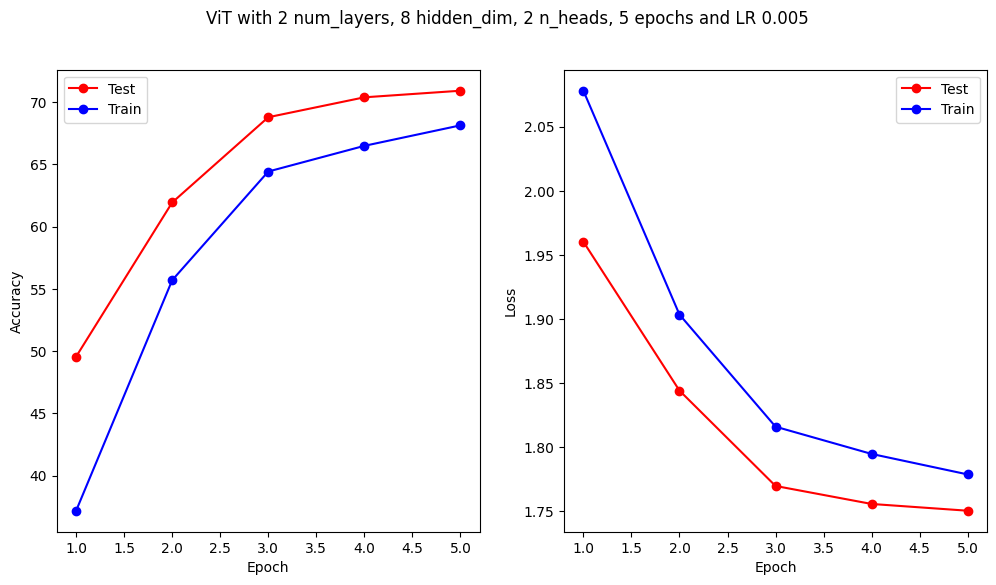

In [36]:
plot_results(
    num_layers,
    num_heads,
    hidden_dim,
    N_EPOCHS,
    LR,
    test_accuracy_metric,
    train_accuracy_metric,
    test_loss_metric,
    train_loss_metric,
)

# show_metrics("./metrics/23-12-07_21-15-28_metrics.npz")

**TODO: Είχα ξεχάσει ότι για κάποιον λόγο το μοντέλο αυτό πηγαίνει κυριολεκτικα
χειρότερα στο training από το test. Να ξανακοιτάξω αν έχω κάνει εγώ κάποιο λάθος
ή αν ο κύριος που το έφτιαξε έκανε εκείνος λάθος**

Παρατηρούμε όμως ότι το μοντέλο που εκπαιδεύσαμε πηγαίνει καλύτερα στο
test dataset και όχι στο train dataset. Αυτό οφείλεται στο γεγονός ότι η
απλή υλοποίηση αυτή δεν εφαρμόζει κάποιες standard τεχνικές μηχανικής
μάθησης, όπως το dropout.

Παρακάτω θα κοιτάξουμε την υλοποίηση της PyTorch για τον Vision Transformer
για να τον συγκρίνουμε με την απλή υλοποίηση του Brian Pulfer.

In [6]:
class VisionTransformerGrayscale(torch.nn.Module):
    """
    Official PyTorch implementation of Vision Transformer with support for Grayscale (1-channel) images.
    Default parameters are for the MNIST dataset.
    """

    def __init__(
        self,
        image_size=28,
        patch_size=7,
        num_layers=6,
        num_heads=6,
        hidden_dim=768,
        mlp_dim=3072,
        num_classes=10,
        dropout=0.1,
    ):
        super(VisionTransformerGrayscale, self).__init__()
        # 1x1 conv to transform 1 channel to 3 channels
        self.conv1 = torch.nn.Conv2d(1, 3, 1)
        self.vit = VisionTransformer(
            image_size=image_size,
            patch_size=patch_size,
            num_layers=num_layers,
            num_heads=num_heads,
            hidden_dim=hidden_dim,
            mlp_dim=mlp_dim,
            num_classes=num_classes,
            dropout=dropout,
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.vit(x)
        return x


Παρατηρούμε αμέσως πως οι παράμετροι αυτού του μοντέλου έχουν τα εξής:
- Πολύ μεγάλο `hidden_dim`
- Παράμετρος που ελέγχει το `mlp_dim`, η οποία *δεν υπάρχει* στην προηγούμενη υλοποίηση
- Dropout, το οποίο επίσης δεν υπήρχε στην προηγούμενη υλοποίηση

Αν θέλουμε μπορούμε να αλλάξουμε τις παραμέτρους σε δικές μας τιμές ή
να τις αφήσουμε όπως ήταν και στο προηγούμενο μοντέλο. Ενναλακτικά μπορούμε να μην
τις πειράξουμε καθόλου και να το τρέξουμε με τις default παραμέτρους
που έχει η PyTorch. 

In [39]:
num_layers = 2
hidden_dim = 8
num_heads = 2
num_classes = 10

mlp_dim = 30
dropout = 0.1

N_EPOCHS = 5
LR = 5e-3

In [41]:
model = VisionTransformerGrayscale(
    num_layers=num_layers,
    num_heads=num_heads,
    hidden_dim=hidden_dim,
    mlp_dim=mlp_dim,
    num_classes=num_classes,
    dropout=dropout,
).to(device)

# Default Parameters
# model = VisionTransformerGrayscale().to(device)

In [47]:
train_loss_metric = []
train_accuracy_metric = []
test_loss_metric = []
test_accuracy_metric = []

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

for epoch in trange(N_EPOCHS, desc="Training"):
    correct, total = 0, 0
    train_loss = 0.0
    # Train
    for batch in tqdm(
        train_loader, desc=f"Epoch {epoch + 1} in training", leave=False, miniters=1
    ):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)
        # print(f"\n\nTrain Loss: {train_loss}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
        # print(f"[TRAIN] We have {correct} corrects and {total} total")

    print(
        f"Epoch {epoch + 1}/{N_EPOCHS} \nTrain loss: {train_loss:.2f}, Train accuracy: {correct / total * 100:.2f}%"
    )

    train_loss_metric.append(train_loss)
    train_accuracy_metric.append(correct / total * 100)

    # Test
    with torch.no_grad():
        correct_test, total_test = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            test_loss += loss.detach().cpu().item() / len(test_loader)
            correct_test += (
                torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            )
            total_test += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct_test / total_test * 100:.2f}%")
        # print(f"[TEST] We have {correct_test} corrects and {total_test} total")
    test_loss_metric.append(test_loss)
    test_accuracy_metric.append(correct_test / total_test * 100)

save_metrics(
    num_layers,
    num_heads,
    hidden_dim,
    mlp_dim,
    N_EPOCHS,
    LR,
    train_accuracy_metric,
    test_accuracy_metric,
    train_loss_metric,
    test_loss_metric
)

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 
Train loss: 0.57, Train accuracy: 81.85%


Training:  20%|██        | 1/5 [00:02<00:09,  2.44s/it]

Test loss: 0.53
Test accuracy: 82.97%


Epoch 2/5 
Train loss: 0.56, Train accuracy: 82.35%


Training:  40%|████      | 2/5 [00:04<00:07,  2.44s/it]

Test loss: 0.53
Test accuracy: 83.40%


Epoch 3/5 
Train loss: 0.55, Train accuracy: 82.66%


Training:  60%|██████    | 3/5 [00:07<00:04,  2.42s/it]

Test loss: 0.53
Test accuracy: 82.88%


Epoch 4/5 
Train loss: 0.54, Train accuracy: 82.92%


Training:  80%|████████  | 4/5 [00:09<00:02,  2.42s/it]

Test loss: 0.50
Test accuracy: 84.43%


Epoch 5/5 
Train loss: 0.53, Train accuracy: 82.97%


Training: 100%|██████████| 5/5 [00:12<00:00,  2.43s/it]

Test loss: 0.49
Test accuracy: 84.74%


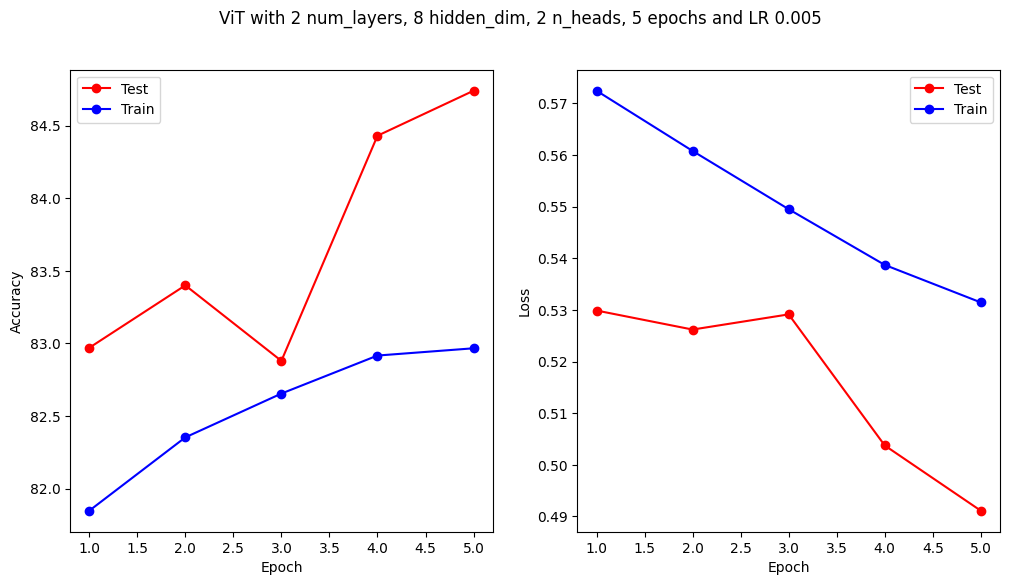

In [48]:
plot_results(
    num_layers,
    num_heads,
    hidden_dim,
    N_EPOCHS,
    LR,
    test_accuracy_metric,
    train_accuracy_metric,
    test_loss_metric,
    train_loss_metric,
)

Παρατηρούμε πως το μοντέλο δεν συμπεριφέρεται ομαλά. Επίσης, η υλοποίηση
της PyTorch είναι αρκετά πιο γρήγορη από του Brian Pufler.

Θα εκπαιδεύσουμε το μοντέλο για περισσότερες εποχές και θα τροποποιήσουμε
τις τιμές των παραμέτρων.

In [9]:
# Parameters from the Paper
num_layers = 6
hidden_dim = 30
num_heads = 6
mlp_dim = 40
dropout = 0.1
num_classes = 10

N_EPOCHS = 20
LR = 5e-3

model = VisionTransformerGrayscale(
    num_layers=num_layers,
    num_heads=num_heads,
    hidden_dim=hidden_dim,
    mlp_dim=mlp_dim,
    num_classes=num_classes,
    dropout=dropout,
).to(device)

In [10]:
metrics = train_loop(
    model,
    train_loader,
    test_loader,
    device,
    num_layers,
    num_heads,
    hidden_dim,
    mlp_dim,
    N_EPOCHS,
    LR,
)

train_loss_metric, train_accuracy_metric, test_loss_metric, test_accuracy_metric = metrics

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20 
Train loss: 1.50, Train accuracy: 44.21%


Training:   5%|▌         | 1/20 [00:03<01:10,  3.72s/it]

Test loss: 0.46
Test accuracy: 85.75%


Epoch 2/20 
Train loss: 0.33, Train accuracy: 89.72%


Training:  10%|█         | 2/20 [00:07<01:06,  3.68s/it]

Test loss: 0.23
Test accuracy: 92.34%


Epoch 3/20 
Train loss: 0.22, Train accuracy: 93.28%


Training:  15%|█▌        | 3/20 [00:11<01:02,  3.67s/it]

Test loss: 0.18
Test accuracy: 94.43%


Epoch 4/20 
Train loss: 0.17, Train accuracy: 94.69%


Training:  20%|██        | 4/20 [00:14<00:58,  3.66s/it]

Test loss: 0.17
Test accuracy: 94.74%


Epoch 5/20 
Train loss: 0.15, Train accuracy: 95.34%


Training:  25%|██▌       | 5/20 [00:18<00:54,  3.66s/it]

Test loss: 0.15
Test accuracy: 95.25%


Epoch 6/20 
Train loss: 0.13, Train accuracy: 95.80%


Training:  30%|███       | 6/20 [00:21<00:51,  3.66s/it]

Test loss: 0.12
Test accuracy: 96.24%


Epoch 7/20 
Train loss: 0.12, Train accuracy: 96.12%


Training:  35%|███▌      | 7/20 [00:25<00:47,  3.65s/it]

Test loss: 0.11
Test accuracy: 96.51%


Epoch 8/20 
Train loss: 0.11, Train accuracy: 96.49%


Training:  40%|████      | 8/20 [00:29<00:43,  3.65s/it]

Test loss: 0.11
Test accuracy: 96.30%


Epoch 9/20 
Train loss: 0.11, Train accuracy: 96.67%


Training:  45%|████▌     | 9/20 [00:32<00:40,  3.65s/it]

Test loss: 0.12
Test accuracy: 96.03%


Epoch 10/20 
Train loss: 0.10, Train accuracy: 96.82%


Training:  50%|█████     | 10/20 [00:36<00:36,  3.65s/it]

Test loss: 0.11
Test accuracy: 96.44%


Epoch 11/20 
Train loss: 0.10, Train accuracy: 97.00%


Training:  55%|█████▌    | 11/20 [00:40<00:32,  3.65s/it]

Test loss: 0.10
Test accuracy: 96.83%


Epoch 12/20 
Train loss: 0.09, Train accuracy: 97.05%


Training:  60%|██████    | 12/20 [00:43<00:29,  3.65s/it]

Test loss: 0.10
Test accuracy: 96.69%


Epoch 13/20 
Train loss: 0.09, Train accuracy: 97.18%


Training:  65%|██████▌   | 13/20 [00:47<00:25,  3.66s/it]

Test loss: 0.10
Test accuracy: 96.80%


Epoch 14/20 
Train loss: 0.09, Train accuracy: 97.28%


Training:  70%|███████   | 14/20 [00:51<00:21,  3.66s/it]

Test loss: 0.10
Test accuracy: 96.64%


Epoch 15/20 
Train loss: 0.08, Train accuracy: 97.31%


Training:  75%|███████▌  | 15/20 [00:54<00:18,  3.65s/it]

Test loss: 0.08
Test accuracy: 97.45%


Epoch 16/20 
Train loss: 0.08, Train accuracy: 97.40%


Training:  80%|████████  | 16/20 [00:58<00:14,  3.65s/it]

Test loss: 0.08
Test accuracy: 97.72%


Epoch 17/20 
Train loss: 0.07, Train accuracy: 97.57%


Training:  85%|████████▌ | 17/20 [01:02<00:10,  3.64s/it]

Test loss: 0.09
Test accuracy: 97.30%


Epoch 18/20 
Train loss: 0.07, Train accuracy: 97.63%


Training:  90%|█████████ | 18/20 [01:05<00:07,  3.64s/it]

Test loss: 0.08
Test accuracy: 97.52%


Epoch 19/20 
Train loss: 0.07, Train accuracy: 97.63%


Training:  95%|█████████▌| 19/20 [01:09<00:03,  3.65s/it]

Test loss: 0.08
Test accuracy: 97.29%


Epoch 20/20 
Train loss: 0.07, Train accuracy: 97.83%


Training: 100%|██████████| 20/20 [01:13<00:00,  3.65s/it]

Test loss: 0.10
Test accuracy: 96.96%


/home/cani/Workspace/vit-research/utils/plotting.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


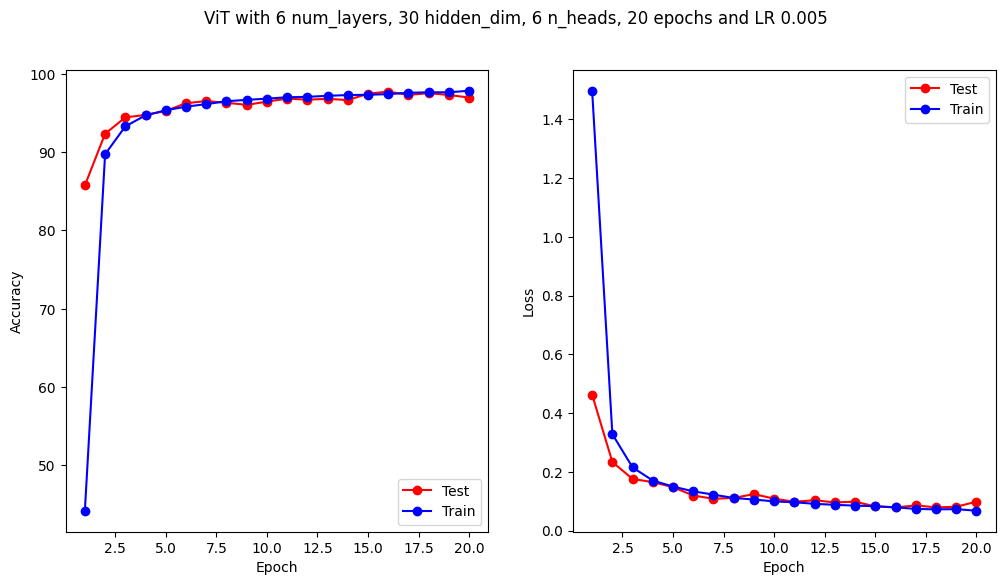

In [11]:
plot_results(
    num_layers,
    num_heads,
    hidden_dim,
    N_EPOCHS,
    LR,
    test_accuracy_metric,
    train_accuracy_metric,
    test_loss_metric,
    train_loss_metric,
)

Βλέπουμε πως με τις καινούριες παραμέτρους έχουμε πολύ καλύτερη απόδοση
στο accuracy και στο loss του μοντέλου μας.

Ας δοκιμάσουμε να δούμε και μια τυχαία εικόνα από το test dataset

Model predicted class 7


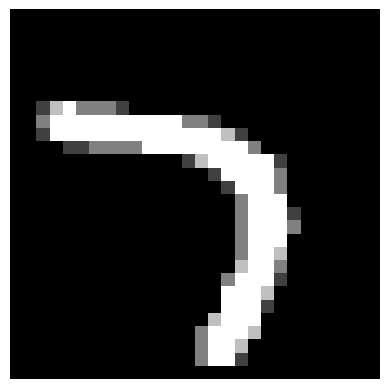

In [28]:
index = 60
image, label = test_loader.dataset[index]

plt.axis("off")
plt.imshow(image.squeeze(), cmap="gray")

prediction = model(image.unsqueeze(0).to(device))
print(f"Model predicted class {torch.argmax(prediction).item()}")